In [1]:
#%matplotlib inline
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date

import createFolder as cF
import calc_date as cd
import plot_sfc_spaghetti as spagh
import save_fig as SF
import get_Haukeli_obs_data as obsDat
import calc_48h_acc as acc
import plot_vertical as pvert
import fill_values as fv

import os

import pandas as pd

In [5]:
# 16th doesnt exist, 17-19 have different shapes
t = [
#    1, 2, 3, 
 #   4, 5, 6 , 
  #  7, 8, 9,10, 11,
   # 12,13,14,15,    
    #17,18,19,
    20#,21,22,23,
#    24,25,26,
 #   27,28,29
  #  ,30#, 31
    ]
year = 2016
month = 12
tid = '00'
#tid = '18'
station = 'Haukeliseter'
savefig = 0  # 1 = yes, 0 = no

### if plot with double fence data
dofe = 1     # 1 = yes, 0 = no

In [6]:
level = 'sfc'

ncdir = '../../MEPS_data/%s/%s_%s' %(station,level,tid)
txtdir = '../../Retrieval'
txt_filename = '201612.Haukeliseter_SC_copy.txt'

var_name = 'precipitation_amount_acc'
unit = '[mm]'
figdir = '../../MEPS_fig/%s' %(var_name)
#var_name = 'liquid_water_content_of_surface_snow'
# Folder where the figures are being saved    
cF.createFolder('%s/' %(figdir))
form = 'png'


/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/get_Haukeli_obs_data.py:56: RuntimeWarning: Mean of empty slice
  dofe = np.nanmean(dofe, axis = 1)


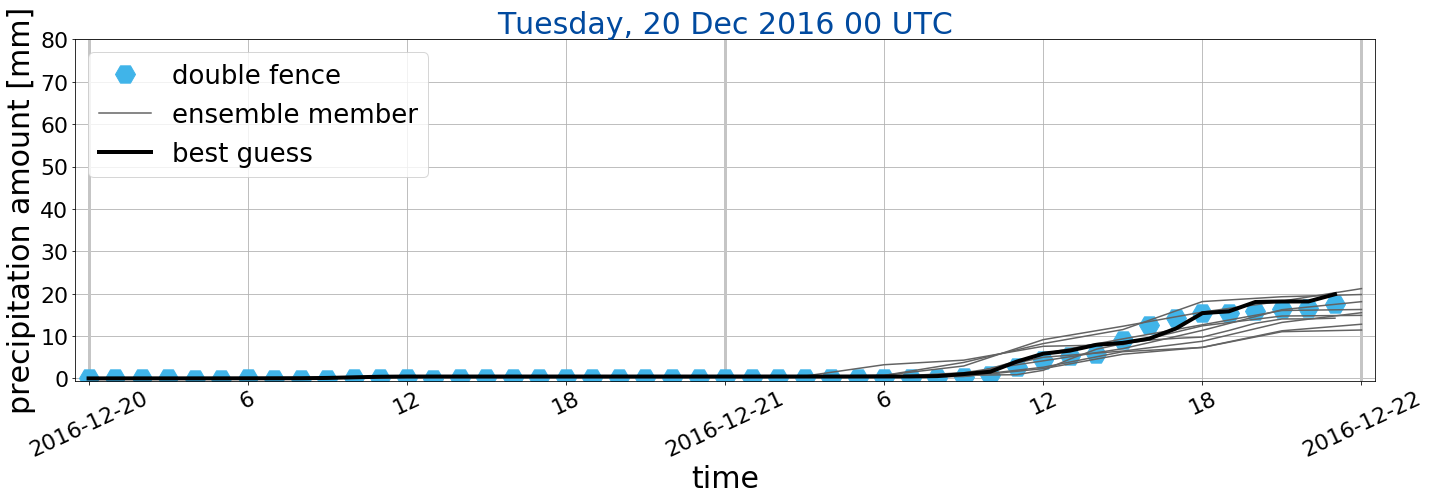

In [7]:
fn_sfc = dict()
time_sfc = dict()
ini_day = []
#hh = []
calday = []
calmon = []
precipitation_amount_acc = dict()
lead_time_sfc = dict()
title = dict()


for day in t:
    if day < 10:
        day = '0%s' %(day)
    else:
        day = '%s' %day
    var_name_sfc = '%s' %(var_name)
    
    for ens_memb in range(0,10):
# read in the netcdf surface file
        fn_sfc[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s_%s.nc' %(ncdir,year,month,day,tid,ens_memb))
        time_sfc[ens_memb] = fn_sfc[ens_memb].variables['time']
        time_sfc[ens_memb] = fv.fill_nan(time_sfc[ens_memb][:])
# initialisation time for plotting
        ini_day = (datetime.datetime.utcfromtimestamp(time_sfc[0][0]).day)   # day of initialisation
        hh = (datetime.datetime.utcfromtimestamp(time_sfc[0][0]).hour)       # first hour of initialisation
        calday, calmon = cd.get_dayname(year, month, ini_day)
# Read in the variable name which should be plotted  
        precipitation_amount_acc[ens_memb] = fn_sfc[ens_memb].variables[var_name]



# lead time
        lead_time_sfc[ens_memb] = np.arange(0,time_sfc[ens_memb].shape[0])
# get only valuable values not nan
        #substitute missing values with nan 
        precipitation_amount_acc[ens_memb] = fv.fill_nan(precipitation_amount_acc[ens_memb][:,:])
# get only valuable values not nan
        time_sfc[ens_memb] = time_sfc[ens_memb][~np.isnan(time_sfc[ens_memb])]
        lead_time_sfc[ens_memb] = lead_time_sfc[ens_memb][~np.isnan(precipitation_amount_acc[ens_memb]).any(axis=1)]
        precipitation_amount_acc[ens_memb] = precipitation_amount_acc[ens_memb][~np.isnan(precipitation_amount_acc[ens_memb]).any(axis=1),:]

# read in the txt Haukeliseter observation file


#### minute values for each day, starting at 00UTC or 18UTC #####
    if tid == '18':
        df, temp, wind_u, wind_v, yy, mm, dd, t = obsDat.create_Hauk_obs_18(txtdir, txt_filename)
    if tid == '00':
        df, temp, wind_u, wind_v, yy, mm, dd, t = obsDat.create_Hauk_obs(txtdir, txt_filename)
    

#### calculate every 60 min the accumulation over 48 hours
    tot_60 = acc.accumulation_dt60_for48h(df)
    

# spaghetti plot with all ensemble member + control
    if ini_day < 10:
        ini_day = '0%s' %(ini_day)
    else:
        ini_day = '%s' %(ini_day)
    
    if hh < 10:
        hh = '0%s' %(hh)
    else:
        hh = '%s' %(hh)
        
    fig_name = '%s%s%s_%s.png' %(year,month,ini_day,hh)
    title = '%s, %s %s %s %s UTC' %(calday,ini_day,calmon,year,hh)
    var_name_sfc = var_name_sfc.split("_")
    

    Xmax = np.asarray(tot_60)[:,(int(day)-1)].shape[0]
    
    spagh.spaghetti_sfc_dofe(lead_time_sfc, precipitation_amount_acc, tot_60, time_sfc[0], Xmax, 
                                day, var_name_sfc, unit, title, tid, dofe)

    if savefig == 1:
        SF.save_figure_landscape(figdir, fig_name, form)
        print('plot saved: %s/%s' %(figdir,fig_name))
    else:
        plt.show()
    plt.close()    
        
    for ens_memb in range(0,10):
        fn_sfc[ens_memb].close()
    